In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 2.6 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=66a60cfa4d164ec815af2abfbe09da55c5973b7694bf2e13c13706ce815d499f
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
import glob
import os
from functools import reduce
from pathlib import Path

import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OneHotEncoder

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



# Exploration des données

In [ ]:
!mkdir ~/.kaggle
username = ""
key = ""
!echo '{"username":username,"key":key}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c home-credit-default-risk

100% 688M/688M [00:06<00:00, 115MB/s]
100% 688M/688M [00:06<00:00, 115MB/s]


In [ ]:
!unzip home-credit-default-risk.zip

Archive:  home-credit-default-risk.zip
  inflating: HomeCredit_columns_description.csv  
  inflating: POS_CASH_balance.csv    
  inflating: application_test.csv    
  inflating: application_train.csv   
  inflating: bureau.csv              
  inflating: bureau_balance.csv      
  inflating: credit_card_balance.csv  
  inflating: installments_payments.csv  
  inflating: previous_application.csv  
  inflating: sample_submission.csv   


In [ ]:
!ls

application_test.csv		    home-credit-default-risk.zip
application_train.csv		    installments_payments.csv
bureau_balance.csv		    POS_CASH_balance.csv
bureau.csv			    previous_application.csv
credit_card_balance.csv		    sample_data
HomeCredit_columns_description.csv  sample_submission.csv


In [ ]:
path = r"/content"
all_files = glob.glob(path + "/*.csv")
all_files = sorted(all_files)

In [ ]:
def get_df(filename):
    df = pd.read_csv(filename, encoding='unicode_escape', delimiter=',')
    return df

In [ ]:
df_names = [str(filename).split("/")[2].rsplit(
    ".csv")[0] for filename in sorted(all_files)]
df_names

['HomeCredit_columns_description',
 'POS_CASH_balance',
 'application_test',
 'application_train',
 'bureau',
 'bureau_balance',
 'credit_card_balance',
 'installments_payments',
 'previous_application',
 'sample_submission']

In [ ]:
HomeCredit_columns_description = get_df(all_files[0])
# POS_CASH_balance = get_df(all_files[1]) 
application_test = get_df(all_files[2]) 
application_train = get_df(all_files[3]) 
bureau = get_df(all_files[4]) 
# bureau_balance = get_df(all_files[5]) 
credit_card_balance = get_df(all_files[6]) 
# installments_payments = get_df(all_files[7]) 
previous_application = get_df(all_files[8]) 
# sample_submission = get_df(all_files[9]) 

In [ ]:
HomeCredit_columns_description.head()

Unnamed: 0  ... Special
0           1  ...     NaN
1           2  ...     NaN
2           5  ...     NaN
3           6  ...     NaN
4           7  ...     NaN

[5 rows x 5 columns]

In [ ]:
pd.set_option('display.max_colwidth', None)
HomeCredit_columns_description[
    HomeCredit_columns_description["Row"] == "DAYS_BIRTH"]["Description"]

153    Balance during the month of previous credit
Name: Description, dtype: object

In [ ]:
# # avec target 
# application_train.head()

In [ ]:
# application_test.head()

In [ ]:
application_train.shape

(307511, 122)

In [ ]:
bureau.shape

(1716428, 17)

In [ ]:
# precedent loans
# bureau.head()

In [ ]:
# relevés bancaires
# credit_card_balance.head()

In [ ]:
# précédentes demandes de prêt
# previous_application.head()

In [ ]:
# on choisit de se concentrer sur application_train
application_train.shape

(307511, 122)

#### Valeurs manquantes

In [ ]:
bureau = bureau[["CREDIT_TYPE", "DAYS_CREDIT", "AMT_CREDIT_SUM", "SK_ID_CURR"]]

In [ ]:
credit_card_balance = credit_card_balance[["AMT_BALANCE", "SK_ID_CURR"]]

In [ ]:
previous_application = previous_application[["AMT_APPLICATION", 
                                              "NAME_CASH_LOAN_PURPOSE", 
                                              "NAME_GOODS_CATEGORY", 
                                              "NAME_PRODUCT_TYPE", 
                                             "SK_ID_CURR"]]

In [ ]:
dfs = [application_train, bureau, credit_card_balance, previous_application]

In [ ]:
def col_to_delete(df, ratio):
    missing_values_ratio = df.isnull().sum()/df.shape[0]*100
    check_relevance = missing_values_ratio[missing_values_ratio>ratio].index
    for column in check_relevance:
        df = df.drop([column], axis=1)
    return df


In [ ]:
dfs = [col_to_delete(df, 32) for df in dfs]

In [ ]:
for i in range(4):
    print(dfs[i].shape)

(307511, 73)
(1716428, 4)
(3840312, 2)
(1670214, 5)


In [ ]:
application_train = dfs[0]

In [ ]:
bureau = dfs[1]

In [ ]:
credit_card_balance = dfs[2]

In [ ]:
previous_application = dfs[3]

#### Aggrégation et merge

In [ ]:
def most_frequent(serie):
    return "".join(serie.value_counts()[0:1].index)

In [ ]:
dict((key,"first") for key in application_train.columns)

{'AMT_ANNUITY': 'first',
 'AMT_CREDIT': 'first',
 'AMT_GOODS_PRICE': 'first',
 'AMT_INCOME_TOTAL': 'first',
 'AMT_REQ_CREDIT_BUREAU_DAY': 'first',
 'AMT_REQ_CREDIT_BUREAU_HOUR': 'first',
 'AMT_REQ_CREDIT_BUREAU_MON': 'first',
 'AMT_REQ_CREDIT_BUREAU_QRT': 'first',
 'AMT_REQ_CREDIT_BUREAU_WEEK': 'first',
 'AMT_REQ_CREDIT_BUREAU_YEAR': 'first',
 'CNT_CHILDREN': 'first',
 'CNT_FAM_MEMBERS': 'first',
 'CODE_GENDER': 'first',
 'DAYS_BIRTH': 'first',
 'DAYS_EMPLOYED': 'first',
 'DAYS_ID_PUBLISH': 'first',
 'DAYS_LAST_PHONE_CHANGE': 'first',
 'DAYS_REGISTRATION': 'first',
 'DEF_30_CNT_SOCIAL_CIRCLE': 'first',
 'DEF_60_CNT_SOCIAL_CIRCLE': 'first',
 'EXT_SOURCE_2': 'first',
 'EXT_SOURCE_3': 'first',
 'FLAG_CONT_MOBILE': 'first',
 'FLAG_DOCUMENT_10': 'first',
 'FLAG_DOCUMENT_11': 'first',
 'FLAG_DOCUMENT_12': 'first',
 'FLAG_DOCUMENT_13': 'first',
 'FLAG_DOCUMENT_14': 'first',
 'FLAG_DOCUMENT_15': 'first',
 'FLAG_DOCUMENT_16': 'first',
 'FLAG_DOCUMENT_17': 'first',
 'FLAG_DOCUMENT_18': 'first',


In [ ]:
_agg = {'AMT_ANNUITY': 'sum',
 'AMT_CREDIT': 'sum',
 'AMT_GOODS_PRICE': 'sum',
 'AMT_INCOME_TOTAL': 'sum',
 'AMT_REQ_CREDIT_BUREAU_DAY': 'sum',
 'AMT_REQ_CREDIT_BUREAU_HOUR': 'sum',
 'AMT_REQ_CREDIT_BUREAU_MON': 'sum',
 'AMT_REQ_CREDIT_BUREAU_QRT': 'sum',
 'AMT_REQ_CREDIT_BUREAU_WEEK': 'sum',
 'AMT_REQ_CREDIT_BUREAU_YEAR': 'sum',
 'CNT_CHILDREN': 'max',
  'CNT_FAM_MEMBERS': 'first',
 'CODE_GENDER': 'first',
 'DAYS_BIRTH': 'first',
 'DAYS_EMPLOYED': 'first',
 'DAYS_ID_PUBLISH': 'first',
 'DAYS_LAST_PHONE_CHANGE': 'first',
 'DAYS_REGISTRATION': 'first',
 'DEF_30_CNT_SOCIAL_CIRCLE': 'first',
 'DEF_60_CNT_SOCIAL_CIRCLE': 'first',
 'EXT_SOURCE_2': 'first',
 'EXT_SOURCE_3': 'first',
 'FLAG_CONT_MOBILE': 'first',
 'FLAG_DOCUMENT_10': 'first',
 'FLAG_DOCUMENT_11': 'first',
 'FLAG_DOCUMENT_12': 'first',
 'FLAG_DOCUMENT_13': 'first',
 'FLAG_DOCUMENT_14': 'first',
 'FLAG_DOCUMENT_15': 'first',
 'FLAG_DOCUMENT_16': 'first',
 'FLAG_DOCUMENT_17': 'first',
 'FLAG_DOCUMENT_18': 'first',
 'FLAG_DOCUMENT_19': 'first',
 'FLAG_DOCUMENT_2': 'first',
 'FLAG_DOCUMENT_20': 'first',
 'FLAG_DOCUMENT_21': 'first',
 'FLAG_DOCUMENT_3': 'first',
 'FLAG_DOCUMENT_4': 'first',
 'FLAG_DOCUMENT_5': 'first',
 'FLAG_DOCUMENT_6': 'first',
 'FLAG_DOCUMENT_7': 'first',
 'FLAG_DOCUMENT_8': 'first',
 'FLAG_DOCUMENT_9': 'first',
 'FLAG_EMAIL': 'first',
 'FLAG_EMP_PHONE': 'first',
 'FLAG_MOBIL': 'first',
 'FLAG_OWN_CAR': 'first',
 'FLAG_OWN_REALTY': 'first',
 'FLAG_PHONE': 'first',
 'FLAG_WORK_PHONE': 'first',
 'HOUR_APPR_PROCESS_START': 'first',
 'LIVE_CITY_NOT_WORK_CITY': 'first',
 'LIVE_REGION_NOT_WORK_REGION': 'first',
 'NAME_CONTRACT_TYPE': 'first',
 'NAME_EDUCATION_TYPE': 'first',
 'NAME_FAMILY_STATUS': 'first',
 'NAME_HOUSING_TYPE': 'first',
 'NAME_INCOME_TYPE': 'first',
 'NAME_TYPE_SUITE': 'first',
 'OBS_30_CNT_SOCIAL_CIRCLE': 'first',
 'OBS_60_CNT_SOCIAL_CIRCLE': 'first',
 'OCCUPATION_TYPE': 'first',
 'ORGANIZATION_TYPE': 'first',
 'REGION_POPULATION_RELATIVE': 'first',
 'REGION_RATING_CLIENT': 'first',
 'REGION_RATING_CLIENT_W_CITY': 'first',
 'REG_CITY_NOT_LIVE_CITY': 'first',
 'REG_CITY_NOT_WORK_CITY': 'first',
 'REG_REGION_NOT_LIVE_REGION': 'first',
 'REG_REGION_NOT_WORK_REGION': 'first',
 'SK_ID_CURR': 'first',
 'TARGET': 'first',
 'WEEKDAY_APPR_PROCESS_START': 'first'
}

In [ ]:
_agg_bur   = {'AMT_CREDIT_SUM': 'sum',
 'CREDIT_TYPE': lambda x: most_frequent(x),
 'DAYS_CREDIT': lambda x: abs(min(x))}

In [ ]:
_agg_prev  = {'AMT_APPLICATION': 'sum',
 'NAME_CASH_LOAN_PURPOSE': most_frequent,
 'NAME_GOODS_CATEGORY': most_frequent,
 'NAME_PRODUCT_TYPE': most_frequent}

In [ ]:
_agg_cash = {"AMT_BALANCE":"sum"}

In [ ]:
def agg_df(df, dict_agg):
    df = df.groupby(["SK_ID_CURR"]).agg(dict_agg)
    return df

In [ ]:
df_train = agg_df(application_train, _agg)

In [ ]:
df_bur = agg_df(bureau, _agg_bur)

In [ ]:
df_prev = agg_df(previous_application, _agg_prev)

In [ ]:
df_ccb = agg_df(credit_card_balance,_agg_cash)

In [ ]:
df = pd.concat([df_train, df_bur, df_prev, df_ccb], axis=1)

In [ ]:
df.shape

(356070, 81)

In [ ]:
#### valeurs manquantes sur le dataframe mergé

In [ ]:
# nombre de lignes ayant des valeurs manquantes
rows_unfilled = df.isnull().any(axis=1).sum()
rows_unfilled / df.shape[0] * 100

85.98028477546549

In [ ]:
# on check le % de valeurs manquantes
missing_values_ratio = df.isnull().sum()/df.shape[0]*100

In [ ]:
fig = px.bar(df, df.columns, missing_values_ratio,
             labels={"x":"Variables de application_train",
                     "y":"% de valeurs manquantes"},
                     color_discrete_sequence=["firebrick"], 
             title="% de valeurs manquantes dans le dataframe aggrégé")
fig.show()

In [ ]:
df = df.dropna()

In [ ]:
df.shape

(49920, 81)

In [ ]:
#check for duplicates
set(df.duplicated())

{False}

#### Evaluation de l'importance des variables

In [ ]:
df.std().describe()

count    6.500000e+01
mean     1.426274e+05
std      6.093651e+05
min      0.000000e+00
25%      4.957742e-02
50%      2.886427e-01
75%      2.359457e+00
max      3.337988e+06
dtype: float64

In [ ]:
fig = px.bar(y=df.std(), x=df.std().index, title="Variance des variables",
             labels={"x": "Variables", "y":"Variance"})
fig.update_yaxes(range=[0,0.2])
fig.show()

##### on fixe le seuil de variance minimal à 0.1


In [ ]:
to_del = []
for col in df.std().index:
    if df[col].std()<0.1:
        to_del.append(col)

In [ ]:
df = df.drop(to_del, axis=1)

In [ ]:
df.shape

(49920, 59)

In [ ]:
df.head()

AMT_ANNUITY  AMT_CREDIT  ...  NAME_PRODUCT_TYPE  AMT_BALANCE
SK_ID_CURR                           ...                                
100023          17563.5    544491.0  ...                XNA        0.000
100043          23157.0    641173.5  ...                XNA  6882895.800
100047          35028.0   1193580.0  ...             x-sell        0.000
100049          16258.5    288873.0  ...                XNA   626382.855
100059          34596.0    675000.0  ...                XNA        0.000

[5 rows x 59 columns]

#### One hot encoding des variables catégorielles

In [ ]:
onehotencoder = OneHotEncoder()

In [ ]:
to_encode = list(set(df.columns) - set(df._get_numeric_data().columns))

In [ ]:
def one_hot(df, column):
    serie = onehotencoder.fit_transform(
        df[column].values.reshape(-1,1)).toarray()
    return serie

In [ ]:
list_series_enc = [one_hot(df, column) for column in to_encode]

In [ ]:
def one_hot_df(serie, column):
    df = pd.DataFrame(serie, columns = [column+str(int(i)) for i in range(
        serie.shape[1])]) 
    return df

In [ ]:
list_df_enc = [one_hot_df(serie, column) for (serie,column) in zip(
    list_series_enc,to_encode)]
list_df_enc = [df]+list_df_enc

In [ ]:
df_enc = pd.concat(list_df_enc, axis=1)
df_enc = df.drop(to_encode, axis=1) 

In [ ]:
df_enc.to_pickle("./P7_enc.pkl")

In [ ]:
df_enc.head()

AMT_ANNUITY  AMT_CREDIT  ...  AMT_APPLICATION  AMT_BALANCE
SK_ID_CURR                           ...                              
100023          17563.5    544491.0  ...        394987.50        0.000
100043          23157.0    641173.5  ...       8428275.00  6882895.800
100047          35028.0   1193580.0  ...       1455705.00        0.000
100049          16258.5    288873.0  ...        178011.00   626382.855
100059          34596.0    675000.0  ...       3352240.08        0.000

[5 rows x 43 columns]

#### Etude la corrélation

In [ ]:
Matrice_corr = df_enc[df_enc._get_numeric_data().columns].corr()

In [ ]:
pd.set_option('display.max_colwidth', None)
HomeCredit_columns_description[
    HomeCredit_columns_description["Row"] == "AMT_CREDIT_SUM"]["Description"]

132    Current credit amount for the Credit Bureau credit
Name: Description, dtype: object

In [ ]:
redundant_var = ['OBS_60_CNT_SOCIAL_CIRCLE', 'REGION_RATING_CLIENT_W_CITY',
                 'CNT_FAM_MEMBERS', 'REG_REGION_NOT_WORK_REGION', 
                 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 
                 'DEF_60_CNT_SOCIAL_CIRCLE', "REG_REGION_NOT_LIVE_REGION"]

In [ ]:
df_corr = Matrice_corr.abs().unstack().sort_values(
    ascending=False)[43:80].reset_index()  

In [ ]:
df_corr_ = df_corr[~df_corr['level_0'].isin(redundant_var)]

In [ ]:
df_corr__ = df_corr_[~df_corr_['level_1'].isin(redundant_var)]

In [ ]:
df_corr__

level_0           level_1         0
2    AMT_GOODS_PRICE        AMT_CREDIT  0.984584
3         AMT_CREDIT   AMT_GOODS_PRICE  0.984584
14   FLAG_DOCUMENT_3   FLAG_DOCUMENT_8  0.771274
15   FLAG_DOCUMENT_8   FLAG_DOCUMENT_3  0.771274
16   AMT_GOODS_PRICE       AMT_ANNUITY  0.750625
17       AMT_ANNUITY   AMT_GOODS_PRICE  0.750625
18       AMT_ANNUITY        AMT_CREDIT  0.743953
19        AMT_CREDIT       AMT_ANNUITY  0.743953
24       AMT_ANNUITY  AMT_INCOME_TOTAL  0.412515
25  AMT_INCOME_TOTAL       AMT_ANNUITY  0.412515
26  AMT_INCOME_TOTAL    AMT_CREDIT_SUM  0.397233
27    AMT_CREDIT_SUM  AMT_INCOME_TOTAL  0.397233
28   FLAG_WORK_PHONE        FLAG_PHONE  0.373974
29        FLAG_PHONE   FLAG_WORK_PHONE  0.373974
30  AMT_INCOME_TOTAL   AMT_GOODS_PRICE  0.338941
31   AMT_GOODS_PRICE  AMT_INCOME_TOTAL  0.338941
32        AMT_CREDIT  AMT_INCOME_TOTAL  0.337127
33  AMT_INCOME_TOTAL        AMT_CREDIT  0.337127
36        DAYS_BIRTH     DAYS_EMPLOYED  0.307146

In [ ]:
len(set(list(df_corr__.level_0)+list(df_corr__.level_1)))

11

In [ ]:
top = list(set(list(df_corr__.level_0)+list(df_corr__.level_1)))

In [ ]:
_df=df[top+["TARGET"]]

In [ ]:
_df

AMT_INCOME_TOTAL  AMT_CREDIT  ...  FLAG_DOCUMENT_3  TARGET
SK_ID_CURR                                ...                         
100023               90000.0    544491.0  ...              1.0     0.0
100043              198000.0    641173.5  ...              1.0     0.0
100047              202500.0   1193580.0  ...              1.0     1.0
100049              135000.0    288873.0  ...              1.0     1.0
100059              540000.0    675000.0  ...              1.0     0.0
...                      ...         ...  ...              ...     ...
456239              180000.0    808650.0  ...              1.0     0.0
456241              180000.0    270126.0  ...              1.0     0.0
456242              198000.0   1312110.0  ...              0.0     0.0
456246               94500.0    225000.0  ...              1.0     0.0
456247              112500.0    345510.0  ...              1.0     0.0

[49920 rows x 12 columns]

In [ ]:
selector = SelectKBest(score_func=feature_selection.f_regression, k=10)

In [ ]:
Y = _df["TARGET"]
X = _df.drop(['TARGET'], axis = 1)
X= X.abs()
X.head(10)

AMT_INCOME_TOTAL  AMT_CREDIT  ...  FLAG_PHONE  FLAG_DOCUMENT_3
SK_ID_CURR                                ...                             
100023               90000.0    544491.0  ...         1.0              1.0
100043              198000.0    641173.5  ...         1.0              1.0
100047              202500.0   1193580.0  ...         0.0              1.0
100049              135000.0    288873.0  ...         1.0              1.0
100059              540000.0    675000.0  ...         1.0              1.0
100077              180000.0   1256400.0  ...         0.0              1.0
100082              180000.0    450000.0  ...         1.0              1.0
100083              103500.0    573628.5  ...         0.0              1.0
100086              135000.0    675000.0  ...         0.0              1.0
100100              202500.0    796396.5  ...         0.0              1.0

[10 rows x 11 columns]

In [ ]:
selector.fit(X,Y)

X_new = selector.transform(X)
print(X_new.shape)

X.columns[selector.get_support(indices=True)].tolist()
scores = selector.scores_

(49920, 10)


In [ ]:
df_kb = pd.DataFrame(scores, list(X.columns))

In [ ]:
variables_choisies = X.columns[selector.get_support(indices=True)].tolist()

In [ ]:
variables_choisies

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'DAYS_EMPLOYED',
 'DAYS_BIRTH',
 'FLAG_DOCUMENT_8',
 'AMT_GOODS_PRICE',
 'AMT_ANNUITY',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_DOCUMENT_3']

In [ ]:
_df=_df[variables_choisies+['TARGET']]

#### Vérification du besoin de transformation

In [ ]:
for var in _df.columns:
    fig = px.histogram(_df, x=var)
    fig.show()

In [ ]:
transf = ['AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL']

In [ ]:
for var in transf:
    _df[var] = np.log(_df[var])

In [ ]:
for var in transf:
    fig = px.histogram(_df, x=var)
    fig.show()

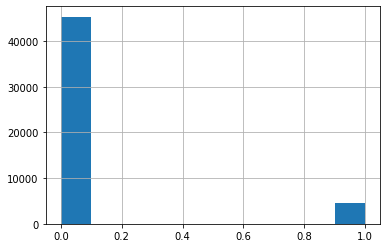

In [ ]:
_df["TARGET"].hist()

In [ ]:
_df.to_pickle("./P7_df_final.pkl")